# notebook 1 - introduction and data processing
This notebook will introduce you to single cell RNA-seq analysis using scanpy. It will walk you through the main steps of an analysis pipeline, taking time to look at the important characteristics of the dataset a long the way. It goes through the individual steps in a more detailed manner than the standard analysis pipeline to teach the core concepts that need to be watched out for when performing single cell analysis.

In [1]:
#import necessary python packages
import scanpy.api as sc #software suite of tools for single-cell analysis in python
import besca as bc #internal BEDA package for single cell analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

sc.logging.print_versions() #output an overview of the software versions that are loaded

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.16.2 scipy==1.4.1 pandas==0.24.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
from IPython.display import HTML
task = "<style>div.task { background-color: #ffc299; border-color: #ff944d; border-left: 7px solid #ff944d; padding: 0.5em;} </style>"
HTML(task)

In [3]:
tag = "<style>div.tag { background-color: #99ccff; border-color: #1a8cff; border-left: 7px solid #1a8cff; padding: 0.5em;} </style>"
HTML(tag)

In [4]:
FAIR = "<style>div.fair { background-color: #d2f7ec; border-color: #d2f7ec; border-left: 7px solid #2fbc94; padding: 0.5em;} </style>"
HTML(FAIR)

## Dataset

The example dataset we will be analyzing today consists of PBMCs taken from 3 healthy donors. The reads have already been demultiplexed to generate a set of FASTQs per donor (cellranger mkfastq function) and count matrices generated (cellranger count function). Afterwards the count matrices from each donor have been merged together into one count matrix and a correct sample annotation generated.

In [5]:
#import example dataset
#filepath = '/path/to/dataset/raw'
#adata = bc.import.read_mtx(filepath=filepath, species='human')
# OR
#adata = sc.read(filepath)
# OR
adata = bc.datasets.pbmc_storage_raw()

In [6]:
adata

AnnData object with n_obs × n_vars = 13066 × 19883 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch'
    var: 'ENSEMBL', 'SYMBOL'

<div class="alert alert-info">

**Note**
    
This dataset contains **15560 cells** (n_obs) and **19883 genes** (n_vars) whose labels are stored in adata.obs_names and adata.var_names respectively. In addition the dataset has been annotated which is stored in adata.obs. In this case each cell has been given the following attributes: CONDITION, experiment, sample_type, storage_condition, Donor, and Batch

</div>  

In [7]:
adata.obs.head(5)

,CELL,CONDITION,experiment,sample_type,storage_condition,donor,batch
index,,,,,,,
6.6K_inhouse_Donor_1_FRESH.AACCGCGAGGGTCTCC-1,6.6K_inhouse_Donor_1_FRESH.AACCGCGAGGGTCTCC-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,fresh,Donor_1,flowcell1
6.6K_inhouse_Donor_3A_24h_RT.GGCAATTCAGACGCCT-1,6.6K_inhouse_Donor_3A_24h_RT.GGCAATTCAGACGCCT-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,24h_RT,Donor_3A,flowcell1
6.6K_inhouse_Donor_2_FROZEN.CGGCTAGAGCTATGCT-1,6.6K_inhouse_Donor_2_FROZEN.CGGCTAGAGCTATGCT-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,frozen,Donor_2,flowcell1
6.6K_inhouse_Donor_2_FRESH.CTCGGGATCCTATGTT-1,6.6K_inhouse_Donor_2_FRESH.CTCGGGATCCTATGTT-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,fresh,Donor_2,flowcell1
6.6K_inhouse_Donor_3A_FROZEN.GCGCGATAGTTCGATC-1,6.6K_inhouse_Donor_3A_FROZEN.GCGCGATAGTTCGATC-1,PBMC_healthy,6.6k_healthy_pbmc_storage_effects_inhouse,PBMC,frozen,Donor_3A,flowcell1


<div class="alert alert-info">

**Note**
    
Since each cell has its own row in adata.obs, we can determing the number of cells that have this specific attribute in the dataset by counting the occurrence of each label.

</div>  

In [8]:
#determine how many CONDITIONS are depicted in the dataset
adata.obs.CONDITION.value_counts()

PBMC_healthy    13066
Name: CONDITION, dtype: int64

In [9]:
#determine how many storage conditions were used in the experiment and how many cells belong to each condition
adata.obs.storage_condition.value_counts()

fresh     5111
24h_RT    5062
frozen    2893
Name: storage_condition, dtype: int64

          donor
Donor_3A   4652
Donor_1    4562
Donor_2    3852


Text(0, 0.5, 'number of cells')

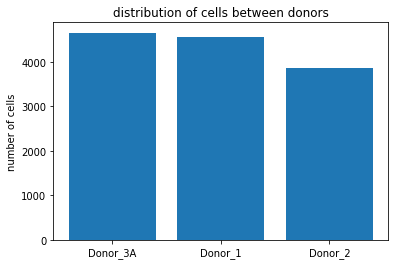

In [10]:
#how many cells came from each donor in the experiment
data_before_filtering = adata.obs.donor.value_counts().to_frame()
print(data_before_filtering)

plt.bar(x=data_before_filtering.index.tolist(), height = data_before_filtering.donor.tolist())
plt.title('distribution of cells between donors')
plt.ylabel('number of cells')

<div class="alert alert-info">

**Note**
    
Its important to check how many cells you get from each Condition/Donor because this is not necessarily always equal as can be seen in our example dataset.

</div>  

## Important quantitative traits of the dataset

First we can take a look at the relationship between total UMI counts associated with a gene and the detection probability in a cell. To do this we will plot the percentage of cells that express a gene (i.e. the cell has at least 1 UMI count for that gene) against the total number of UMI counts that we observe for a gene which we plot on the x-axis.

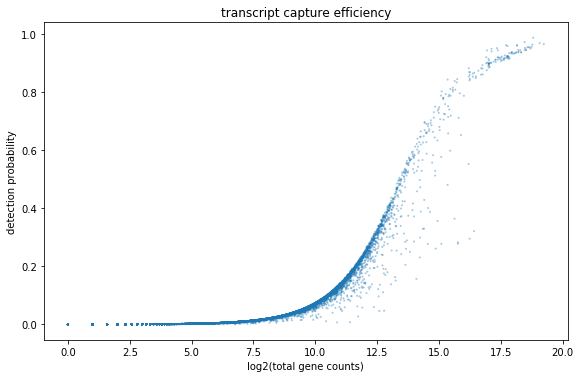

In [11]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)

<div class="alert alert-info">

**Note**
    
As the number of transcripts belonging to a gene increases we can see that most of the cells start expresisng this gene. Which genes these are we will look at in more detail later. Also, the number of genes that are abundantly expressed in most cells is low in comparision to those genes that are only expressed in a small subset of cells.

</div>  

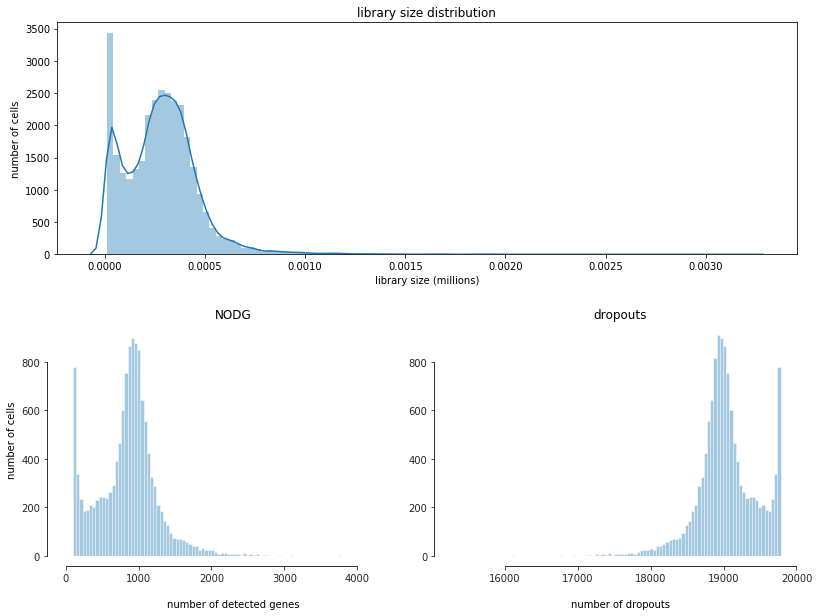

In [12]:
fig = bc.pl.librarysize_overview(adata, bins=100)

<div class="alert alert-info">

**Note**
    
**Library size** refers to the number of unique transcript molecules that are detected in a cell (i.e. the sum of all UMI counts). It is an important value for characterizing the sequencing depth of an experiment.

Librarysize is closely related to two other indices: the **number of detected genes (NODG)** and the number of **dropouts**(undetected genes). Characteristic for single-cell data is the high frequency of dropouts.

</div>  

### sparseness of data

Most of the entries in the UMI count matrix consist of 0's!

In [13]:
count_non_zero = np.count_nonzero(adata.X.todense())
count_all_values = adata.X.todense().size
print('Only', str(round(count_non_zero / count_all_values * 100, 3 ))+ '% of all matrix entries are non-zero values!')
adata.X.todense()[0:10, 0:4]

Only 4.263% of all matrix entries are non-zero values!


matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]], dtype=float32)

## Filtering (Quality Control)

During the quality control we wish to perform a cleanup of the dataset in two dimensions: first to **remove all low quality cells** that might otherwise distort our analysis and second to **remove uninformative genes** (i.e. genes that are not expressed). In general, the quality control is performed in a conservative manner to remove clear outlier cells and not expressed genes but trying to keep as much information as possible. 

There are a number of criteria that can indicate a damaged cell: 
1. a low overall gene/RNA content
2. a high fraction of mitochondrial genes

In addition we also want to **remove any potential cell doublets**. In general cell doublet identification in scRNAseq data is extremely difficult, which is why we follow a conservative approach of removing any cells with an extremely high read count since this might indicate the presence of two cells in a droplet. 

The preliminary removal of uninformative genes is also extremely conservative with us only removing genes that are not expressed in a minimum number of cells.

adding percent mitochondrial genes to dataframe for species human


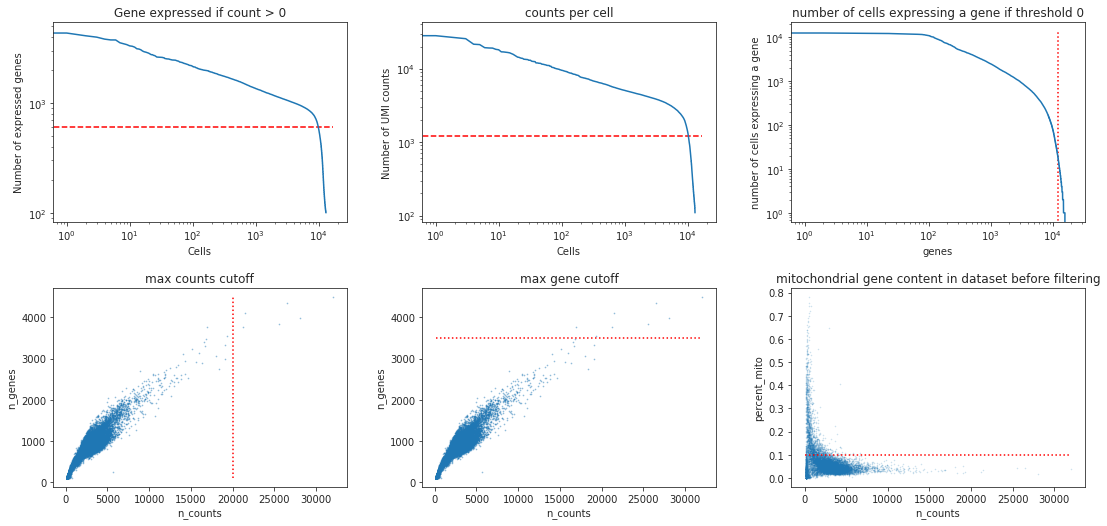

In [14]:
min_genes = 600
min_counts= 1200
min_cells = 20
max_genes = 3500
max_counts = 20000
max_mito = 0.1

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(16)
fig.set_figheight(8)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts = min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=min_cells, ax = ax3)

bc.pl.max_counts(adata, max_counts=max_counts, ax = ax4)
bc.pl.max_genes(adata, max_genes = max_genes, ax = ax5)
bc.pl.max_mito(adata, max_mito=max_mito, annotation_type='SYMBOL', species='human', ax = ax6)

<div class="alert alert-info">

**Note**
    
The specific thresholds chosen to define when a cell is of a low quality or when a gene should be removed from the dataset are strongly dependent on the dataset itself. This is why we always visualize the chosen cutoffs in relation to the distribution of values within the dataset to confirm that the cutoff is reasonable. Choosing the correct cutoff though is, currently, still largely based on the data analysts experience and personal intuition. Since the filtering of cells and genes can have a significant impact on the analysis results, it is extremely important to document the used filtering criteria.

</div>  

In [15]:
adata = bc.pp.filter(adata, max_counts=max_counts, max_genes = max_genes, max_mito = max_mito, min_genes = min_genes, min_cells = min_cells, min_counts = min_counts)

started with  13066  total cells and  19883  total genes
removed 8 cells that expressed more than 3500 genes
removed 3178 cells that did not express at least 600  genes
removed 0 cells that had more than 20000  counts
removed 35 cells that did not have at least 1200 counts
removed 7807 genes that were not expressed in at least 20 cells
removed  384  cells that expressed  10.0 percent mitochondrial genes or more
finished with 9461  total cells and 12076 total genes


In [16]:
adata.obs.donor.value_counts().to_frame()
data_after_filtering = adata.obs.donor.value_counts().to_frame()
display(data_before_filtering)
display(data_after_filtering)

,donor
Donor_3A,4652
Donor_1,4562
Donor_2,3852


,donor
Donor_3A,3877
Donor_1,2932
Donor_2,2652


Text(0, 0.5, 'number of cells')

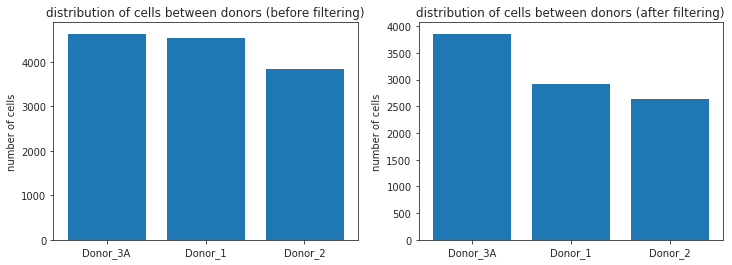

In [17]:
fig = plt.figure(figsize=(12,4))

ax2 = fig.add_subplot(1, 2, 1)
ax2.bar(x=data_before_filtering.index.tolist(), height = data_before_filtering.donor.tolist())
ax2.set_title('distribution of cells between donors (before filtering)')
ax2.set_ylabel('number of cells')

ax1 = fig.add_subplot(1, 2, 2)
ax1.bar(x=data_after_filtering.index.tolist(), height = data_after_filtering.donor.tolist())
ax1.set_title('distribution of cells between donors (after filtering)')
ax1.set_ylabel('number of cells')

<div class="alert alert-info">

**Note**
    
After filtering it is usually a good idea to take another look at the distribution of cells within your dataset since it can occur that one Donor/Condition contained far more low quality cells than the others. Here e.g. Donor_1 seemed to be far less viable than the other Donors.

</div>  

## Characteristics of our cleaned up dataset

In [18]:
#does filtering change anything about the sparseness of our dataset?
count_non_zero = np.count_nonzero(adata.X.todense())
count_all_values = adata.X.todense().size
print('Only', str(round(count_non_zero / count_all_values * 100, 3 )) + '% of all matrix entries are non-zero values!')

Only 8.496% of all matrix entries are non-zero values!


<div class="alert alert-info">

**Note**
    
Even after filtering our matrix to only include viable cells and to eliminate not expressed genes our dataset is still extremley sparse. This is common for single-cell datasets and one of the computational challenges we face in single-cell analysis.

</div>  

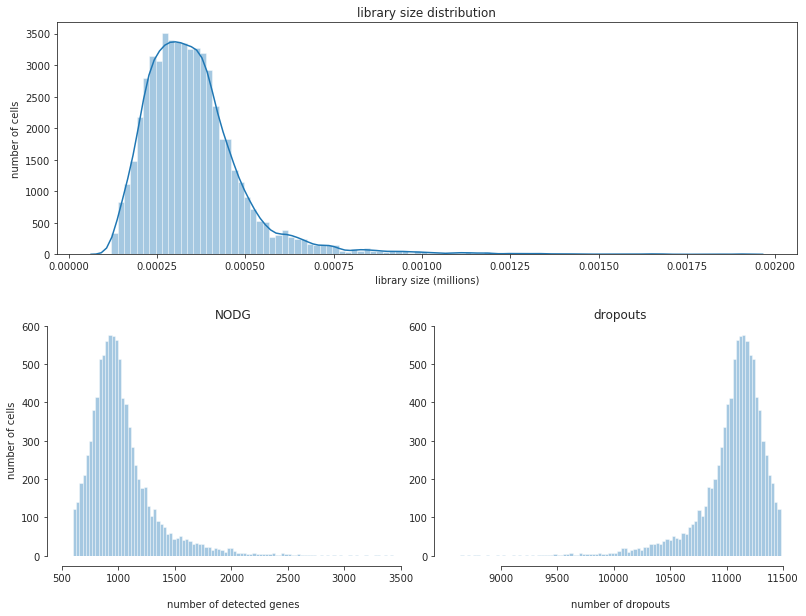

In [19]:
fig = bc.pl.librarysize_overview(adata, bins=100)

<div class="alert alert-info">

**Note**
    
After filtering our librarysize distribution now follows more of a normal distribution. This indicates that we chose good filtering parameters to eliminate the cells that were already dead or empty beads.

</div>  

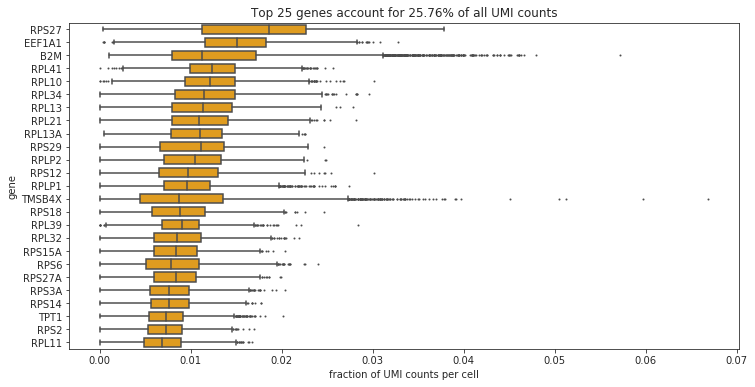

In [20]:
bc.pl.top_genes_counts(adata=adata, top_n=25, ax=None)

<div class="alert alert-info">

**Note**
    
The most strongly and commonly expressed genes are ribosomal and mitochondrial.

</div>  

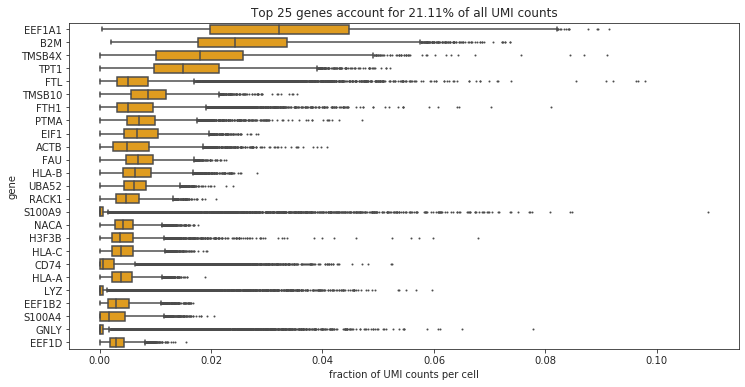

In [21]:
#Thought experiment: what happens if we remove all of the mitochondrial and ribosomal proteins from the dataset?
bdata = adata.copy()
bdata = bdata[:,[not(x.startswith('MT-')) for x in bdata.var_names.tolist()]]
bdata = bdata[:,[not(x.startswith('RP')) for x in bdata.var_names.tolist()]]

bc.pl.top_genes_counts(bdata, top_n = 25, ax = None)

<div class="alert alert-info">

**Note**
    
Now we see a high number of marker genes for Immunecells. Also the variance in expression of these genes is significantly higher (indication for differential expression).

</div>  

## Normalization

Since each cell has a different library size it is common to normalize the UMI counts to each cells library size. In addition we save an additional copy of our dataset at its current status (we refer to this as **cp10k** values) for visualizing gene expression or doing differential gene expression later on.

In [22]:
#before normalization we have discrete counts
adata.X.todense()[0:10, 0:4]

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32)

In [23]:
#normalize per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#save a copy (logarithmized for better understanding of values) to adata.raw
adata.raw = sc.pp.log1p(adata, copy= True)

<div class="fair">
    <p> write out cp10k values for loading into database</p>
    <p> `bc.st.export_cp10k(adata=adata, basepath='FILEPATH_TO_FOLDER_CONTAINING_RAW_SUBFOLDER')` </p>
</div>

In [24]:
#after normalization we have continous values which represent the fraction of reads coming from each gene in a cell per 10000 reads
adata.X.todense()[0:10, 0:4]

matrix([[0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 3.6737695, 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.       , 2.6455028, 0.       , 0.       ],
        [0.       , 1.6504374, 0.       , 0.       ],
        [0.       , 0.       , 2.6961446, 0.       ]], dtype=float32)

Text(0.5, 1.0, 'Top 25 genes account for 25.43% of all counts')

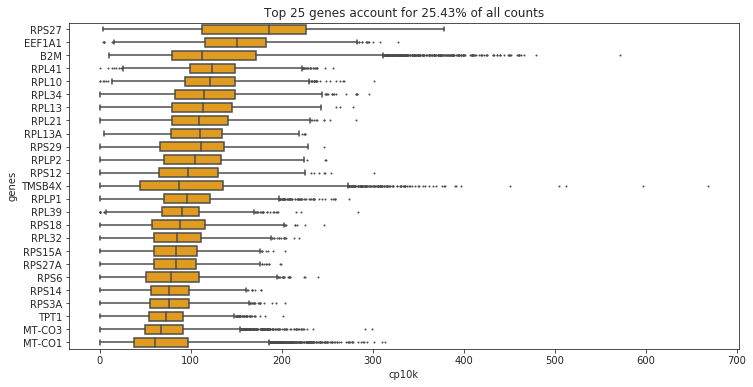

In [25]:
n_top = 25

#calculate total counts and frac_reads
adata.var['total_counts'] = sum(adata.X.toarray())
all_counts = adata.var.total_counts.sum()

if type(adata.X) == np.ndarray:
    adata_X = adata.X
else:
     adata_X = adata.X.toarray() 

#make dataframe to sort
data = pd.DataFrame(data = adata_X, columns = adata.var_names).T
data['total_counts'] = adata.var.total_counts
data.sort_values(ascending=False, by='total_counts', inplace=True)

#get top n values
data = data.head(n_top)

#calculate cummulative Sum
cum_sum = data.total_counts.sum()
cum_sum = cum_sum/all_counts

#remove unwanted columns for plotting
data.drop(columns = ['total_counts'], inplace = True)

#plot results
data = data.head(n_top)
data = data.T

flierprops = dict(marker = "." , markersize=2, linestyle='none')

fig = plt.figure(figsize=(12,6)) # default is (8,6)
fig = sns.boxplot(data=data, orient="h", color='orange', width=0.7, flierprops = flierprops)
fig.set_ylabel('genes')
fig.set_xlabel('cp10k')
fig.set_title('Top '+ str(n_top) + ' genes account for '+ str(round(cum_sum*100, 2)) +'% of all counts')

<div class="alert alert-info">

**What does cp10k mean?**
    
cp10k of 100 means that 100 out of a total of 10000 UMI counts belong to that cell. That is equivalent to a fraction of 0.01 (1%)!

</div>  

## variance in single cell datasets

The characteristic that most strongly sets apart a single-cell RNAseq assay from bulk RNAseq is that measurments are subject to multiple, potent and often confounded sources of variance. Sources of variance can roughly be grouped into **biologial sources of variance** (e.g. cell cycle, cell type heterogeneity, transcriptional bursts, etc.) and **technical sources of variance** (e.g. capture efficiency, PCR amplification bias, contamination, cell damage, etc.). 

### highly variable genes

Variation in gene abundance estimates between different cells can be thought of as the **combination between technical (mainly due to sampling) and biological sources of variance**. Generally one wants to focus on the biological variance and try and eliminate the experimental noise as much as possible.

The technical noise due to sampling is dependent on the expression level of the gene. Genes that are lowly expressed are much more strongly effected by sampling noise since the foldchanges resulting simply from a random sampling can be quite large. This simple intuition is easily visible if you plot the relationship between a gene's dispersion (here the coefficient of variation) and the mean gene expression.

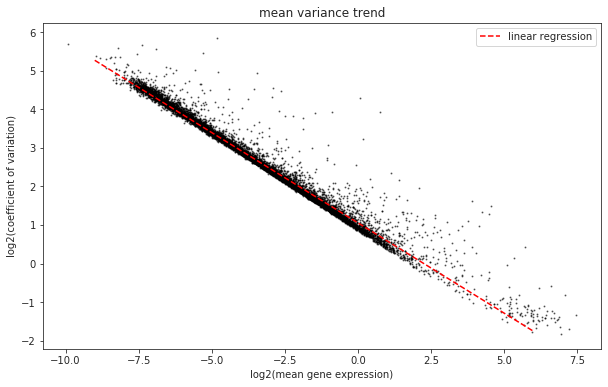

In [26]:
# calculate mean and coefficient of variation for each gene and add to adata.var
adata.var['mean'] = adata.X.todense().mean(axis = 0).tolist()[0]
adata.var['mean_log1p'] = np.log2(adata.var.get('mean').values)
adata.var['coeffvar'] = scipy.stats.variation(adata.X.todense(), axis = 0)
adata.var['coeffvar_log1p'] = np.log2(adata.var.get('coeffvar').values)

#generate a plot of our data to visualize
x = adata.var.mean_log1p.to_frame()
y = adata.var.coeffvar_log1p.to_frame()

#calculate linear fit between mean and cv
from sklearn import linear_model

#generate linear model
lm = linear_model.LinearRegression()
model = lm.fit(x,y)

#make predictions
X = range(int(min(x['mean_log1p'])), int(max(x['mean_log1p'])))
predictions = lm.predict(pd.DataFrame(data = list(X)))

#generate plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x = x, y = y, alpha = 0.5, s=1, color = 'black')
ax.set_xlabel('log2(mean gene expression)')
ax.set_ylabel('log2(coefficient of variation)')
ax.set_title('mean variance trend')
ax.plot(X, predictions, color = 'red', linestyle = 'dashed', label="linear regression")
ax.legend()

The linear fit we calculated (red line) for this dataset represents the expected variance of a gene when the only source of variance is technical. This means that genes that fall above this line are **overdispersed** and should be enriched for genes whose fluctuations represent biological variation. These are the genes we are especially interested in in our analysis which we call **highly variable genes**.

Scanpy also comes with a function to filter highly variable genes according to the above outlined criteria which we will use for filtering.

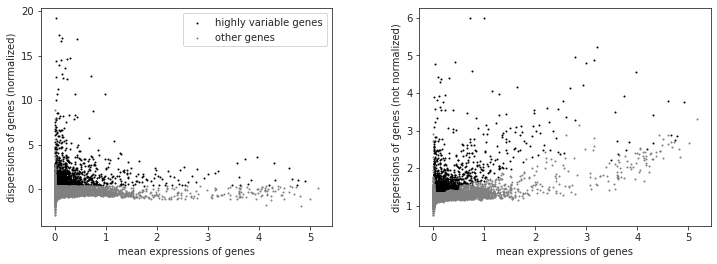

number of variable genes selected  1599


In [27]:
variable_genes_min_mean = 0.01
variable_genes_max_mean = 5
variable_genes_min_disp = 0.4

#identify genes with variable expression
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=variable_genes_min_mean, max_mean=variable_genes_max_mean, min_disp=variable_genes_min_disp) 
sc.pl.filter_genes_dispersion(filter_result)
nbr_variable_genes = sum(filter_result.gene_subset)
print('number of variable genes selected ', nbr_variable_genes )

<div class="alert alert-info">

**Note**
    
the parameters we use for selecting highly variable genes stay constant for most of our analysis! This is not dataset dependent.

</div>  

In [28]:
#count mitochondrial and ribosomal genes in dataset before highly variable gene selection
genes = adata.var_names.tolist()
mito_genes = [i for (i, v) in zip(genes, [x.startswith('MT-') for x in genes]) if v]
ribosomal_genes = [i for (i, v) in zip(genes, [x.startswith('RP') for x in genes]) if v]

In [29]:
#perform the actual filtering
adata = adata[:, filter_result.gene_subset]

<div class="alert alert-info">

**Note**
    
our adata object now **only** contains the highly variable genes, but we still have access to all genes through the adata.raw object we saved earlier specifically for this purpose.

</div>  

In [30]:
#count mitochondrial and ribosomal genes in dataset after highly variable gene selection
highly_var_genes = adata.var_names.tolist()
high_var_mito_genes = [i for (i, v) in zip(highly_var_genes, [x.startswith('MT-') for x in highly_var_genes]) if v]
high_var_ribosomal_genes = [i for (i, v) in zip(highly_var_genes, [x.startswith('RP') for x in highly_var_genes]) if v]

#compare counts before and after filtering
print('Before selection of highly variable genes:')
print("\t Mitochondrial genes: ", str(len(mito_genes)))
print("\t Ribosomal genes: ", str(len(ribosomal_genes)))
print('After selection of highly variable genes:')
print("\t Mitochondrial genes: ", str(len(high_var_mito_genes)))
print("\t Ribosomal genes: ", str(len(high_var_ribosomal_genes)))

Before selection of highly variable genes:
	 Mitochondrial genes:  13
	 Ribosomal genes:  129
After selection of highly variable genes:
	 Mitochondrial genes:  4
	 Ribosomal genes:  8


<div class="alert alert-info">

**Note**
    
By reducing the genes to the highly variable genes we have significantly reduced the number of mitochondrial and ribosomal genes in our dataset. Depending on the analysis it might make sense though to completely remove the mitochondrial and ribosomal genes before hand. In our standard analysis pipeline we leave them in since removing them does entail removing additional information.

</div>  

In [31]:
hist1_dat = adata.X.todense()

In [32]:
#log transform our data (is easier to work with numbers like this)
sc.pp.log1p(adata)

In [33]:
## To do: Currently not working:
#fig = plt.figure(figsize=(15,6))
#
##visualize distribution before logarithmization
#ax1 = fig.add_subplot(1, 2, 1)
#ax1 = sns.distplot(hist1_dat.flatten());
#ax1.set_title('Distribution of values before logarithmization');
#ax1.set_ylabel('frequency')
#ax1.set_xlabel('cp10k')
#
##visualize distribution after logarithmization
#ax2 = fig.add_subplot(1, 2, 2)
#ax2 = sns.distplot(adata.X.todense().flatten());
#ax2.set_title('Distribution of values after logarithmization');
#ax2.set_ylabel('frequency');
#ax2.set_xlabel('log1p(cp10k)');

<div class="alert alert-info">

**Explanation of log1p()**
\begin{equation}
log1p(x)   = \ln{(x+1)}
\end{equation}

The +1 is necessary to ensure that if there are counts of 0 we do not get an NA (logarithm of 0 is undefined)

remember that a logarithmic scale is not linear! A log1p(cp10k) value of 5 represents roughly 150 UMI counts and one of 8 already almost 3000!

</div>  

### unwanted sources of variance

As we have already seen part of the observed variation in the dataset is coming from sources that are not biological (e.g technical batch, library size) but there are also sources of variance that are biological in nature but trivial and unrelated to the question we want to address (e.g. cells in different cell cycle stages or apoptotic vs healthy cells). 

One approach to overcoming these issues is to explicitly correct for this unwanted source of variation (e.g. using regress out). This can only be applied though if the source of variance is known and can be identified. Such approaches also run the risk of overcorrecting the data which is why they should be used sparingly. 

In our analysis pipeline we correct for two basic sources of additional variance whose effect we have already calculated above: the number of counts per cell and the mitochondrial gene content per cell. 

In [34]:
#define several input factors
random_seed = 0 #define a random seed so that for stochastic processes you get reproducible results
max_value = 10

In [35]:
#remove variance due to difference in counts and percent mitochondrial gene content
adata = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], copy=True)

In [36]:
sc.pp.scale(adata, max_value=10) # Scale data to unit variance and zero mean, and cut-off at max value 10

<div class="fair">
    <p> write out regressedOut values for loading into database</p>
    <p> `bc.st.export_regressedOut(adata = adata, basepath='FILEPATH_TO_FOLDER_CONTAINING_RAW_SUBFOLDER')` </p>
</div>

In [37]:
## batch correction would occur here if performed
## will write out AnnData object to demonstrate batch correction later
adata.write('/tmp/adata_pbmc_FRESH_regressedOut.h5ad')

## dimension reduction

One of the distinguishing characteristics of single-cell RNAseq data is the high dimensionality of the dataset. For each individual cell we have the entire transcriptome (albeit in a sparse format). One of the key steps in single-cell analysis is to apply methods to reduce the number of dimensions we look when we e.g. want to identify cell groupings that encompass biological subtypes.

**Overview**  
**step 1**: principle component analysis (PCA)  
**step 2**: nearest neighbor calculation based on the top 50 principle components  
**step 3**: clustering to identify cell groupings (i.e. clusters)    
**step 4**: visualization of high dimensional data on two dimensions (tSNE and UMAP)  

### Principle component analysis

A principal component analysis is an approach that seeks to identify summary features (called components) that are linear combinations of different variables in the dataset. Each principle component is orthogonal to all other components and tries to capture the maximum dispersion not yet explained by previous components. Therefore, each added component will account for progressively lower fractions of the overall dataset features. As a result you can use a PCA to describe a dataset using a much lower number of features (here principle components) thus reducing the dimensionality of the dataset. 

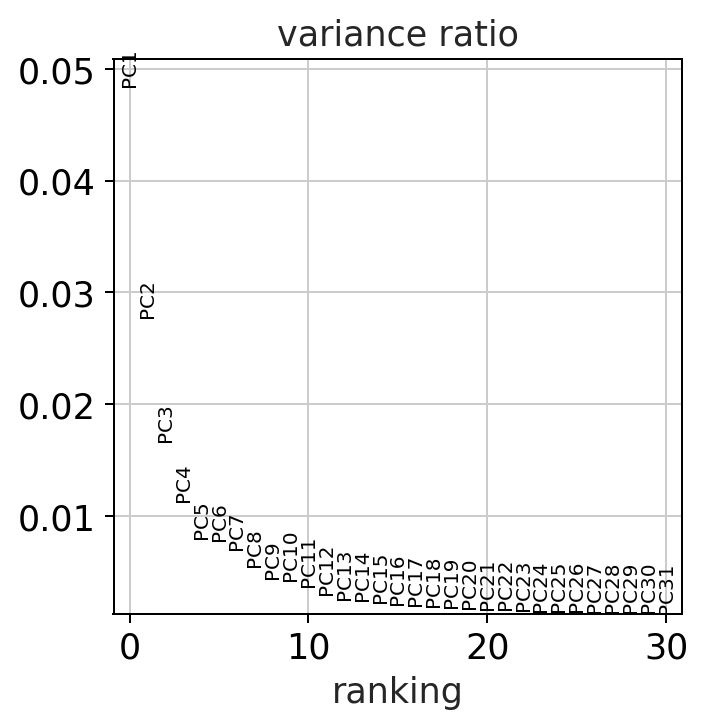

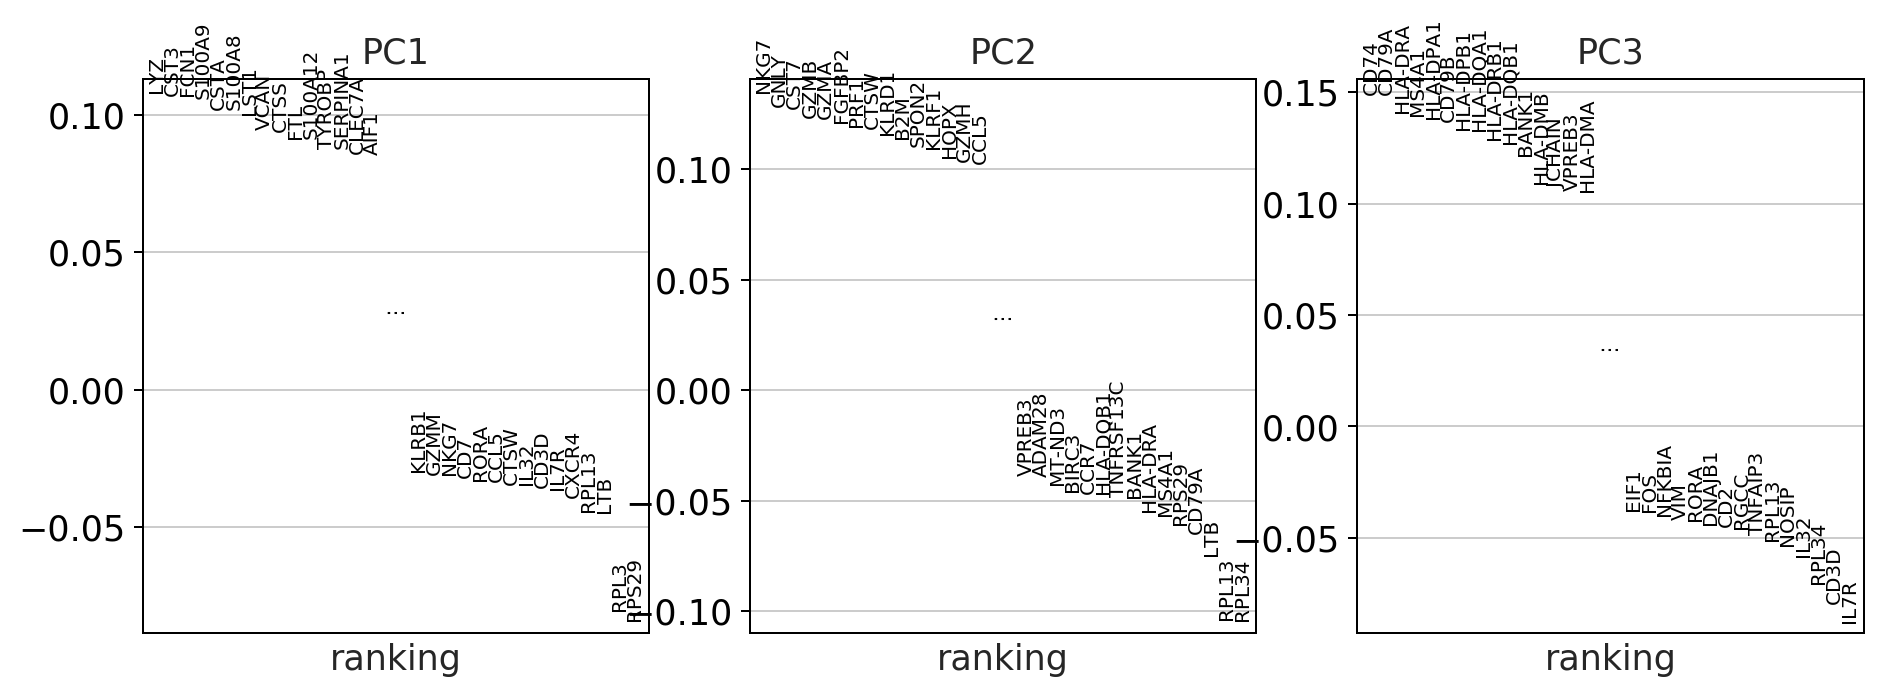

In [38]:
sc.settings.set_figure_params(dpi=90)

#calculate 50 principle components of the dataset
sc.tl.pca(adata, random_state=random_seed, svd_solver='arpack')

#visualize the amount of variance explained by each PC
sc.pl.pca_variance_ratio(adata)

#visualize the loadings onto the first 3 PCs
sc.pl.pca_loadings(adata)

<div class="alert alert-info">

**Note**
    
compared to bulk RNAseq datasets the fraction of variance explained by each principle component is much lower in single-cell datasets due to the extremely high dimensionality of the dataset. This is why other dimensionality reduction techniques are used.

</div>  

### nearest neighbor calculation

Computes a neighborhood graph of the cells based on the first 50 principle components.

In [39]:
sc.pp.neighbors(adata, n_neighbors=15, random_state = random_seed, n_pcs=50)

### louvain clustering

In [40]:
sc.tl.louvain(adata, random_state=random_seed)

### UMAP & t-SNE

In [41]:
%%time
sc.tl.umap(adata, random_state = random_seed)

CPU times: user 24.5 s, sys: 124 ms, total: 24.6 s
Wall time: 24.5 s


In [42]:
%%time
sc.tl.tsne(adata, random_state = random_seed)

CPU times: user 1min 9s, sys: 158 ms, total: 1min 9s
Wall time: 1min 9s


<div class="alert alert-info">

**Note**
    
For larger datasets the tSNE calculation can run significantly longer than the umap calculation. Here we have speed up the process through use of an additional python package which allows tSNE to run on multiple cores in parallel.

</div>  

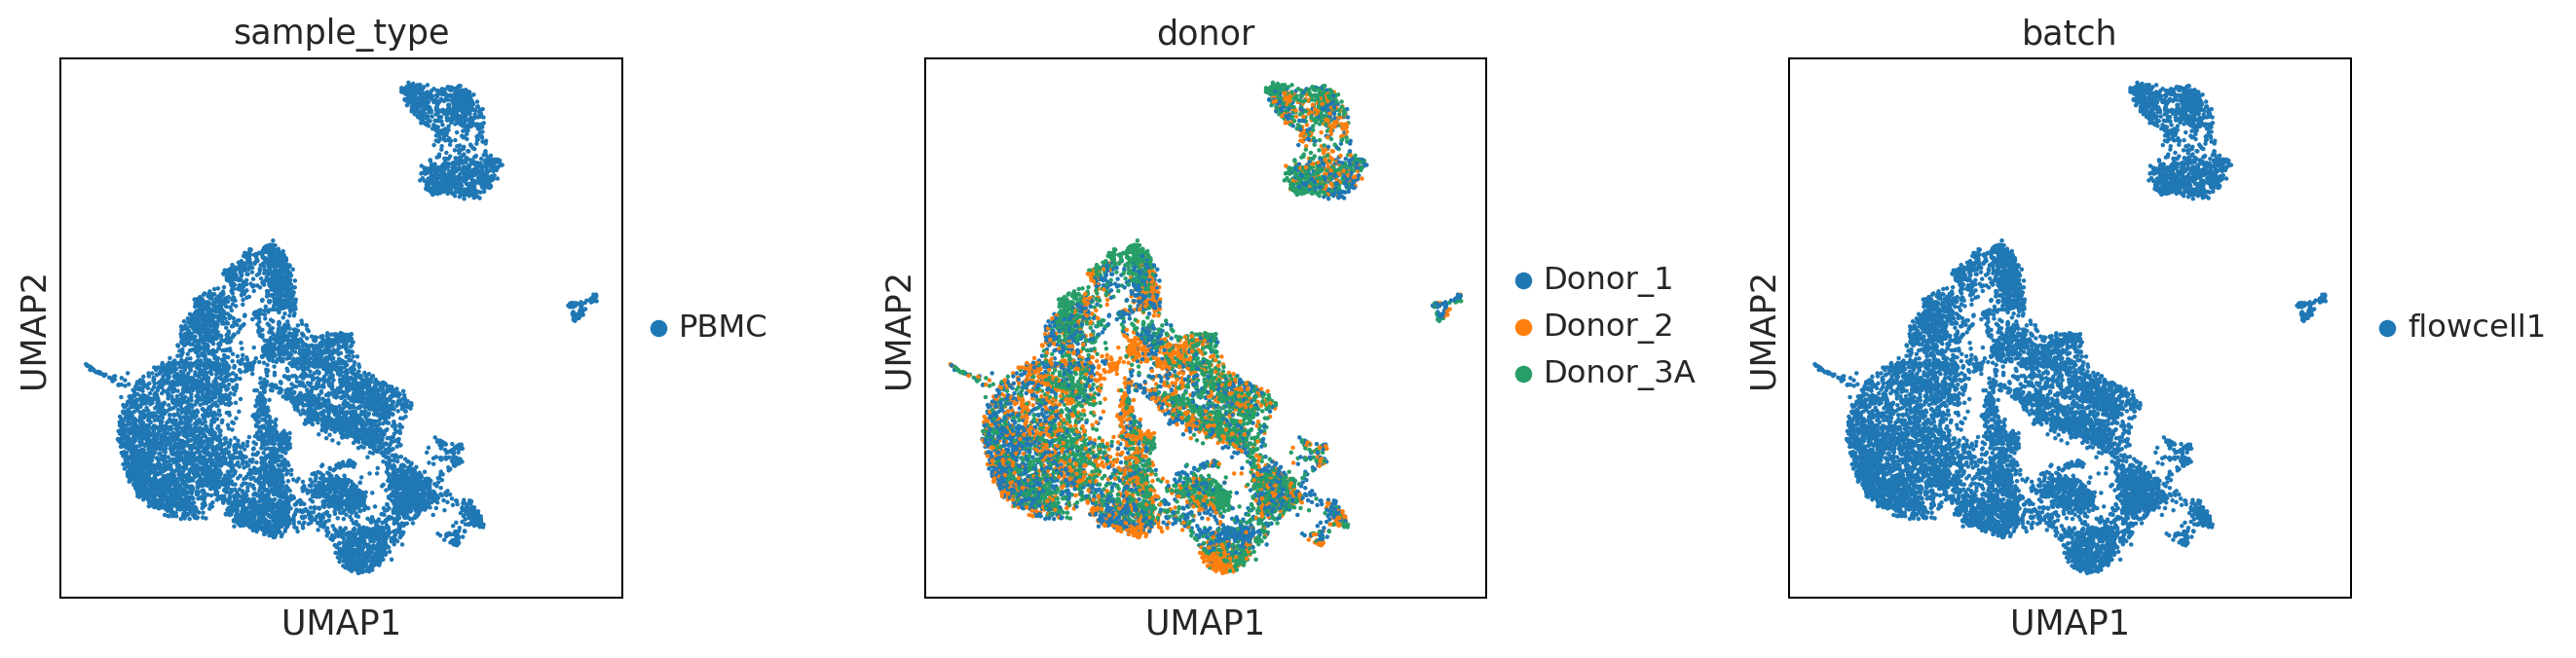

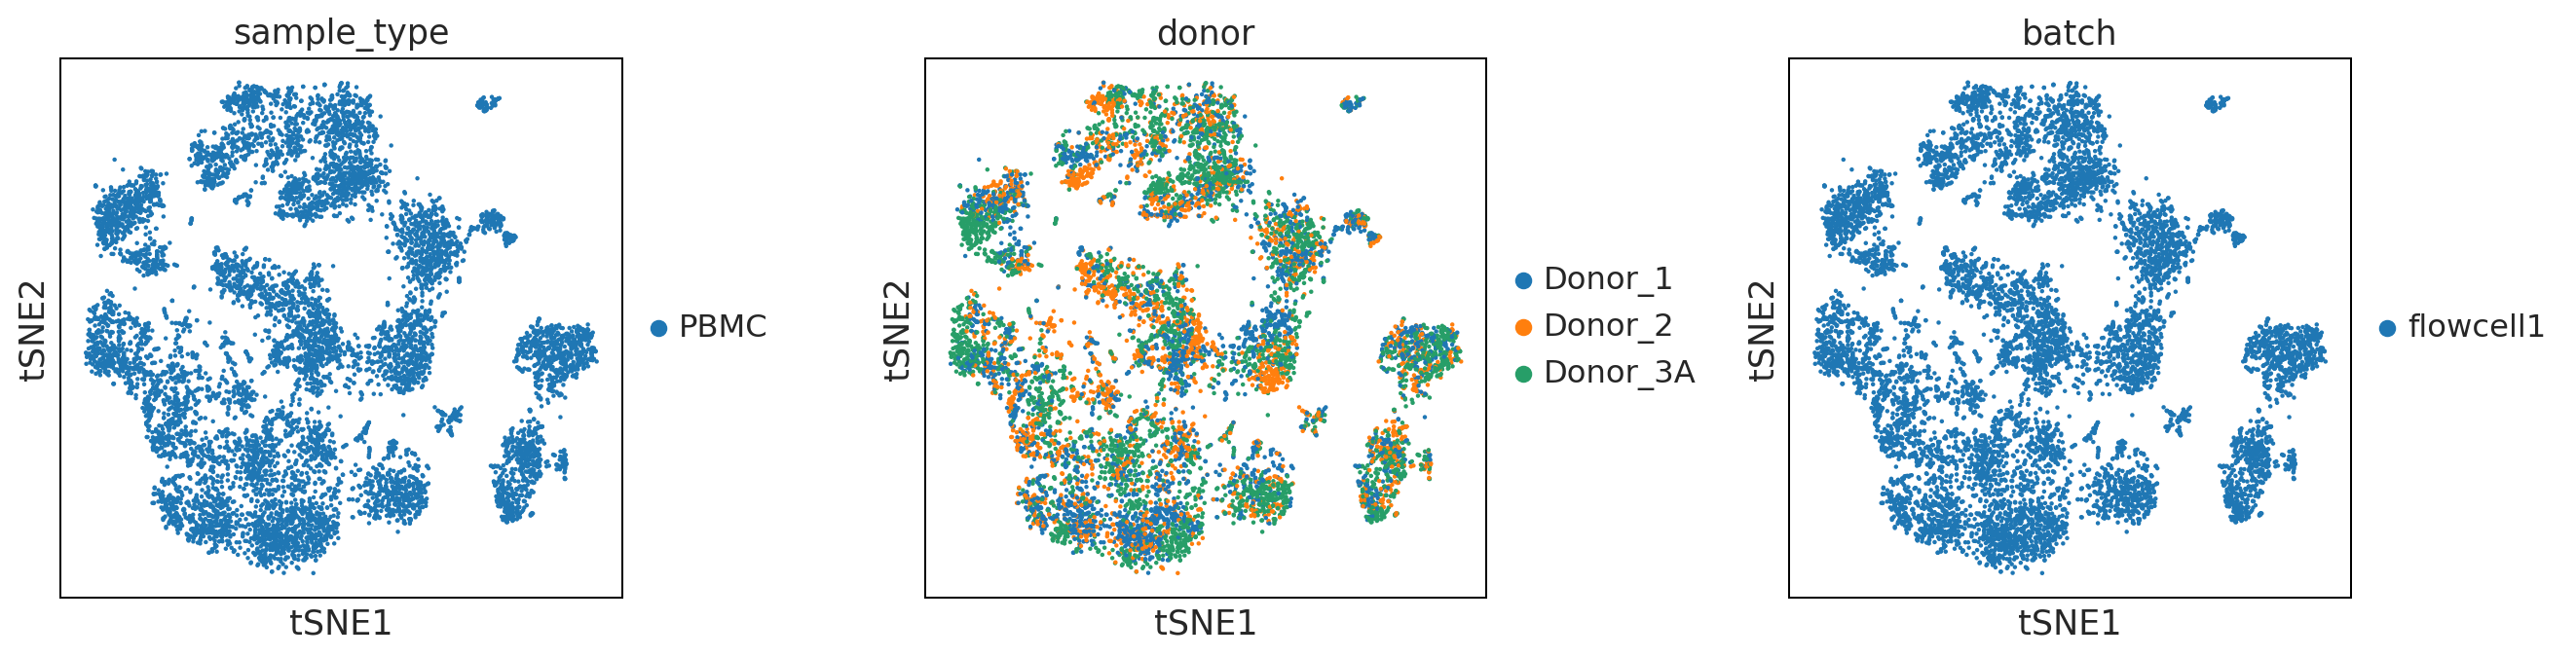

In [43]:
sc.pl.umap(adata, color = ['sample_type', 'donor', 'batch'], wspace = 0.4)
sc.pl.tsne(adata, color = ['sample_type', 'donor', 'batch'], wspace = 0.4)

<div class="alert alert-info">

**Differences between UMAP and t-SNE**
    
UMAP performs better at preserving aspects of **global structure** of the data than tSNE, where as t-SNE only conserves **local structure**. This is extremely important to keep in mind when interpreting the data. As a note both UMAP and t-SNE do not represent clustering methods!

</div>  

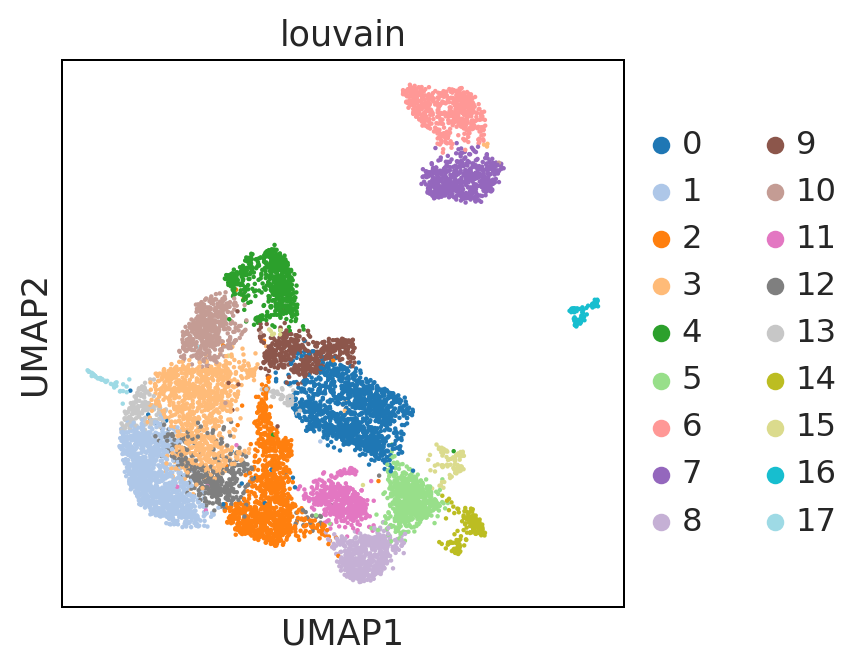

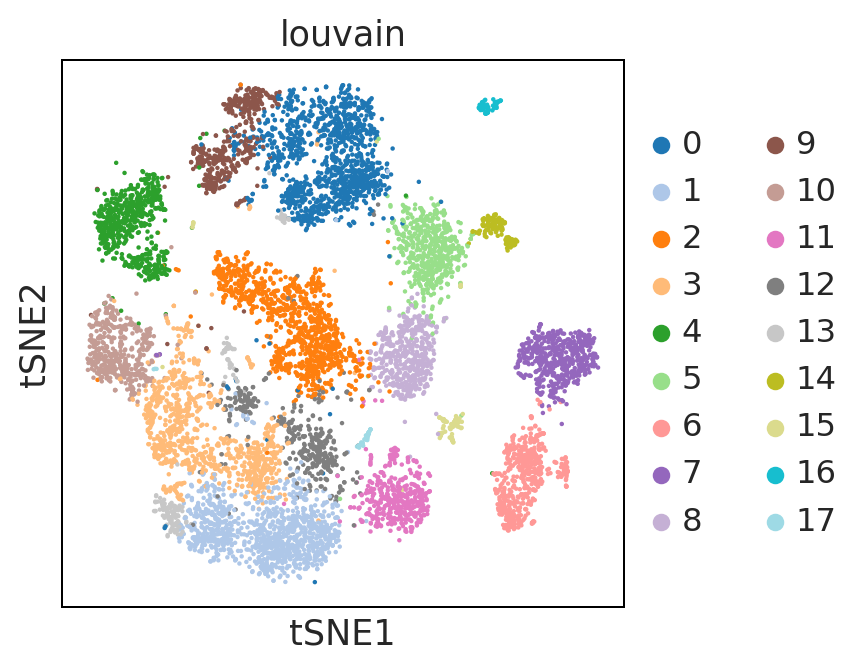

In [44]:
sc.pl.umap(adata, color = ['louvain'], palette = 'tab20')
sc.pl.tsne(adata, color = ['louvain'], palette = 'tab20')

<div class="fair">
**Standard Pipeline Export:**

write out louvain clusters and generated metadata values (i.e. PCA, UMAP and tSNE coordinates) for loading into database

`bc.st.export_louvain(adata = adata, basepath='FILEPATH_TO_FOLDER_CONTAINING_RAW_SUBFOLDER')`

`bc.st.export_metadata(adata=adata, basepath='FILEPATH_TO_FOLDER_CONTAINING_RAW_SUBFOLDER', n_pcs=3, tsne=True, umap=True)`
</div>

In [45]:
#write out our AnnData Object to reload this analysis point
adata.write('/tmp/adata_pbmc_FRESH_processed.h5ad')